# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before. But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain Libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

Our dataset is a subset of the Food101 dataset. Food101 starts with 101 different classes of food and a 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, ~25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data(data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  """ Walk through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza.


In [6]:
# Setup train and testing paths
train_dir = image_path /"train"
test_dir = image_path/"test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with image, let's open the image with Python's PIL
5. We'll then show the image and print metada


Random image path: data/pizza_steak_sushi/test/pizza/309892.jpg
Image class: 309892
Image height: 333
Image width: 512


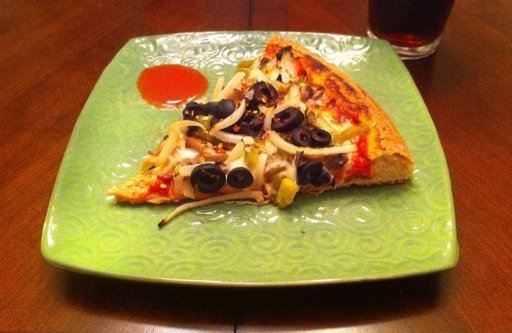

In [7]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path =random.choice(image_path_list)

# 3. Get the image class from the path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metada
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


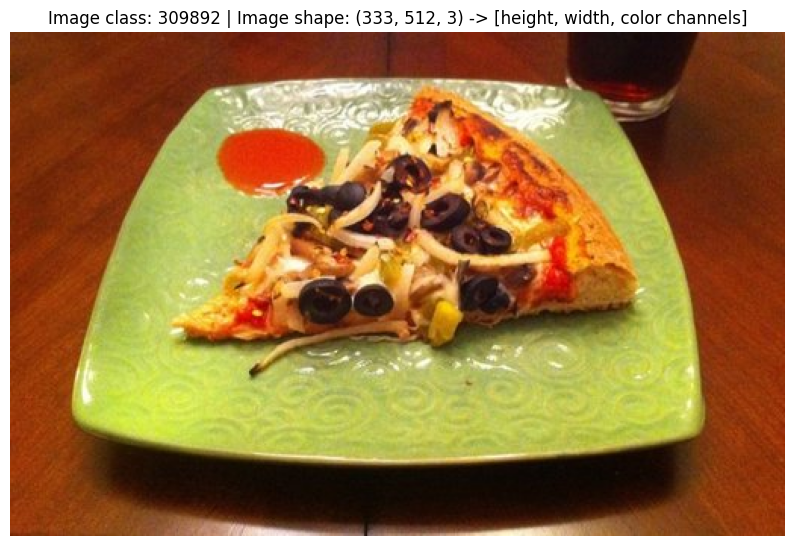

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape: {img_array.shape} -> [height, width, color channels]")
plt.axis(False);

array([[[119,  55,  20],
        [121,  57,  22],
        [119,  55,  19],
        ...,
        [128,  60,  21],
        [138,  69,  28],
        [137,  65,  25]],

       [[114,  50,  15],
        [113,  49,  14],
        [113,  49,  14],
        ...,
        [130,  62,  23],
        [136,  67,  26],
        [139,  67,  27]],

       [[119,  54,  22],
        [114,  50,  15],
        [115,  51,  16],
        ...,
        [131,  66,  26],
        [132,  63,  22],
        [139,  67,  27]],

       ...,

       [[143,  58,  19],
        [139,  54,  15],
        [143,  55,  17],
        ...,
        [139,  51,   5],
        [139,  48,   4],
        [142,  53,   9]],

       [[128,  46,   9],
        [127,  45,   7],
        [131,  47,  10],
        ...,
        [142,  56,   9],
        [137,  48,   4],
        [140,  53,   8]],

       [[112,  34,   0],
        [117,  39,   1],
        [124,  44,   7],
        ...,
        [142,  58,  11],
        [137,  50,   5],
        [139,  55,   9]]], dtype=uint8)
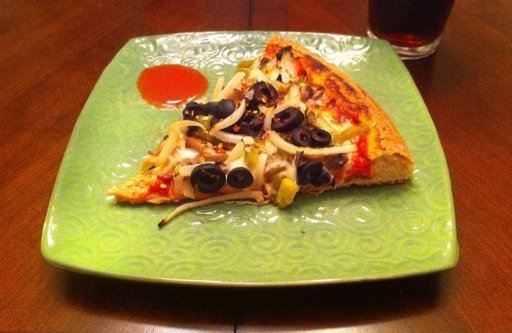

In [9]:
img_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmenation - https://pytorch.org/vision/0.9/transforms.html

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

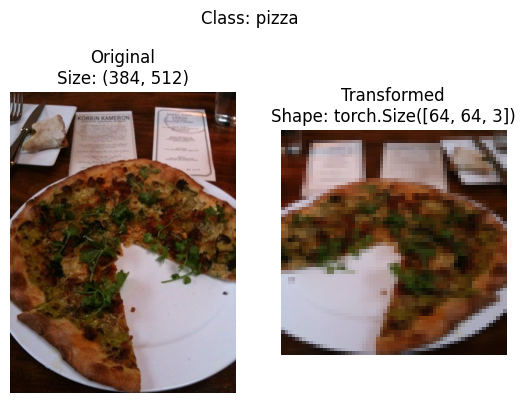

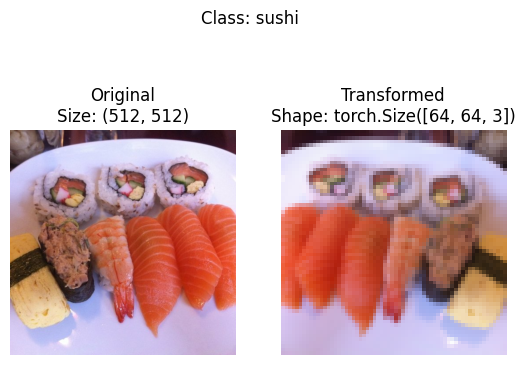

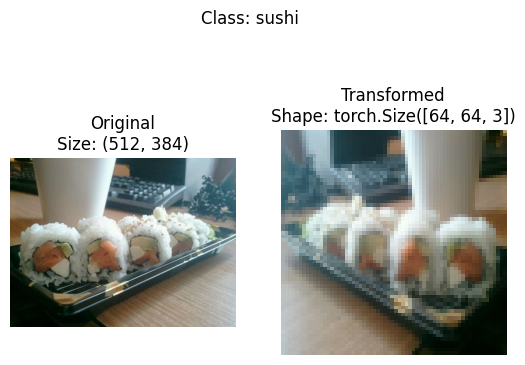

In [13]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.
  """
  if seed:
    random.seed(42)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows =1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # Note we will need to change shape for matplotlib (C,H,W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 12)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n = 3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/0.9/datasets.html?highlight=imagefolder#imagefolder

In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, #tranform for the data
                                  target_transform=None) # transform for the label
test_data = datasets.ImageFolder(root=test_dir,
                                 transform = data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the len of our datasets
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


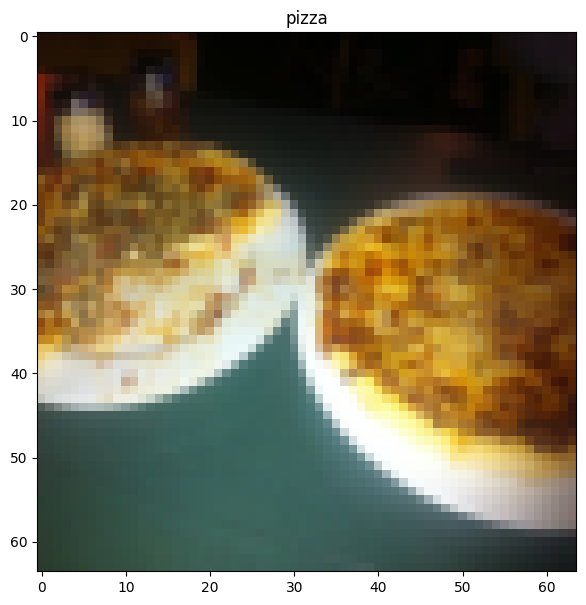

In [19]:
# Rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# Print ou different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(None)
plt.title(class_names[label], fontsize=12);

### 4.1 Turn loaded images into `DataLoader's`

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [20]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset= train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle= True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size =BATCH_SIZE,
                            num_workers =1,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c8713093790>,
 <torch.utils.data.dataloader.DataLoader at 0x7c8713043e90>)

In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, widht]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, widht]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to erros of performance issues.

All custom datasets in PyTorch, often subclass these:

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standar image classification format).
2. Raise an error if the class names aren't found (if this happens, there migth be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them.

In [25]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary of index labels (conputers prefer nnumbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transfomr if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transforms - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to interger labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [28]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Init our custom dataset
  def __init__(self, targ_dir: str, transform = None):
    # 3. Create class atributtes
    # Get all images path
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Function to load imags
  def load_images(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) ->int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() to return a particular sample
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X,y)"
    img = self.load_images(index)
    class_name = self.paths[index].parent.name # epects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # retunr data, label (X,y)
    else:
      return img, class_idx # return untransform image and label


In [29]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c87130a5ad0>,
 <__main__.ImageFolderCustom at 0x7c87130919d0>)

In [31]:
len(train_data), len(train_data_custom)

(225, 225)

In [32]:
len(test_data), len(test_data_custom)

(75, 75)

In [33]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [36]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int =10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n> 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing and shape display")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n )

  # 5. Setup a plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # Plot adjusted samples
    plt.subplot(1,n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


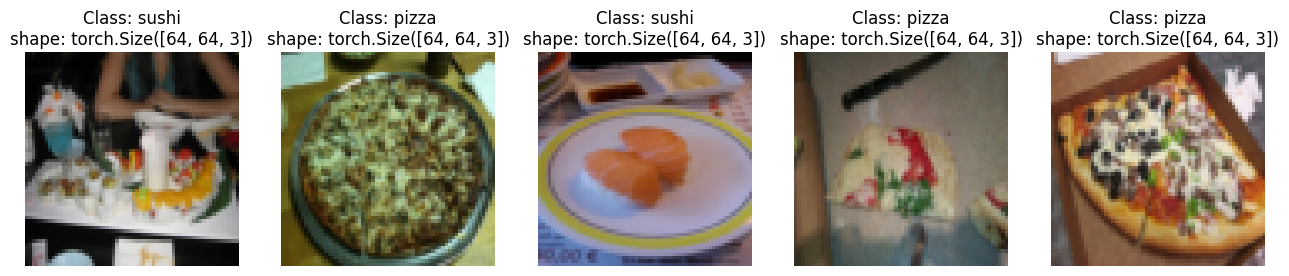

In [37]:
# Display random images from the ImageFolder created Dataset
display_random_images(dataset=train_data,
                      n = 5,
                      classes = class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing and shape display


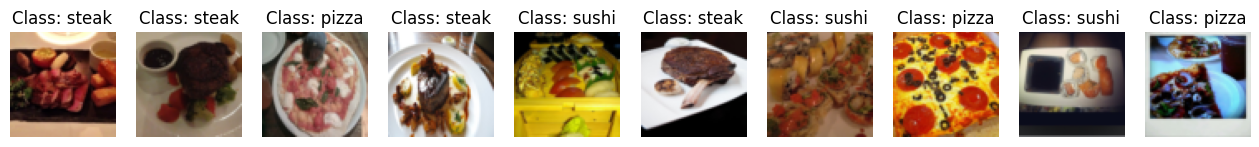

In [38]:
# Display random image rom the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes = class_names,
                      seed=None)

###5.4 Turn custom loaded images into `DataLoader`'s

In [39]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers=0,
                                    shuffle= False)

test_dataloader_custom, train_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c8713091090>,
 <torch.utils.data.dataloader.DataLoader at 0x7c8712998310>)

In [40]:
# GEt image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transfomrs (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post here: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [41]:
# Let' look at trivailagument
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intentense
    transforms.ToTensor() # to get everything between 1 & 0
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [42]:
image_path

PosixPath('data/pizza_steak_sushi')

In [43]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/3142045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2087958.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1621763.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/937133.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1615395.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/176508.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/234626.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/225990.jpg')]

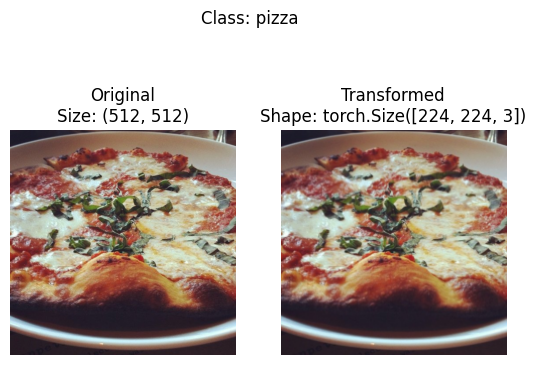

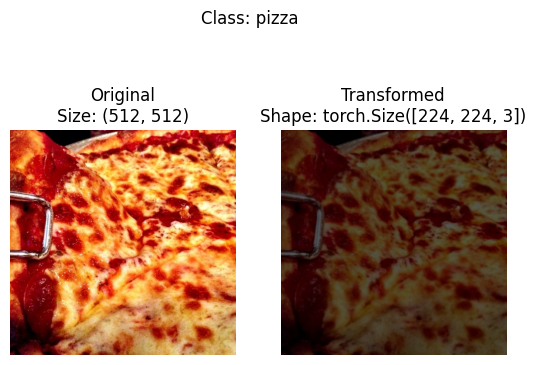

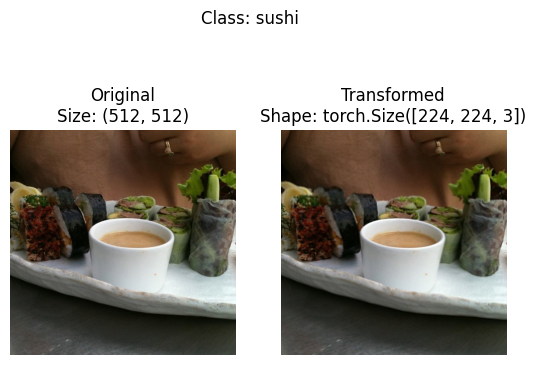

In [44]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate the TinyVGG architecture from the CNN explainer website

### 7.1 Creating transforms and loading data for Model

In [45]:
# Create simple transforms
simple_tranform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [46]:
# Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                  transform = simple_tranform,
                                  target_transform = None)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_tranform)

In [47]:
# Turn the datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                              batch_size = BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

### 7.2 Create TinyVGG model class

In [48]:
class TinyVGG(nn.Module):
  """ Model architecture copying TinyVGG from CNN Explainer """
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride value same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # default stride value same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x

In [49]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channles in our image data
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [50]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [51]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [52]:
# Install torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

 * `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
 * `test_step()` - takes in a model and a dataloader and evaluates the model on the dataloader.

In [53]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [54]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [55]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate `model_0`

In [56]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinnyVGG
model_0 = TinyVGG(input_shape =3, #number of color chanels of our target images
                   hidden_units = 10,
                   output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
print (f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0842 | train_acc: 0.3984 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0654 | test_acc: 0.5644
Total training time: 9.898 seconds


### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of track your model's progress over time.

In [57]:
# Get the model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [58]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """ Plots training curves of a results dictionary"""

  # Get the loss values of the resuls dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the acc values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_loss, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

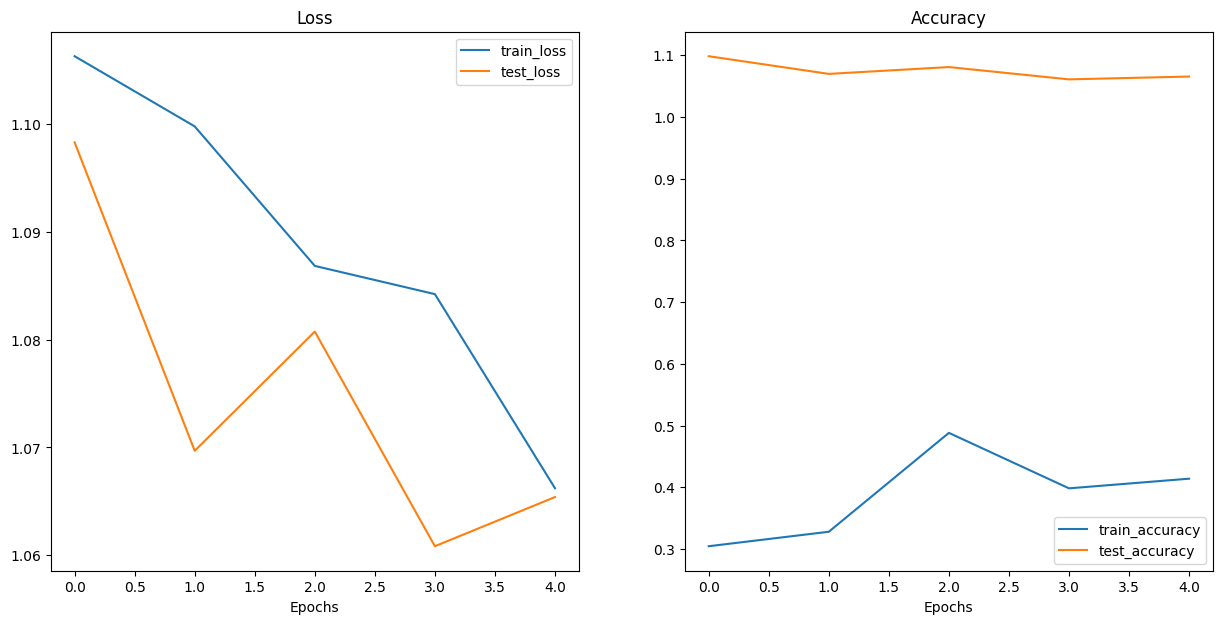

In [59]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmenation.

### 9.1 Create transform with data augmentation

In [60]:
# Create training transform with TrivailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`'s and `Dataloader`'s with data augmentation

In [61]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform = train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                          transform = test_transform_simple)


In [62]:
# Turn datatasets into dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [63]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and a dataloaders, let's create a loss function and an optimizer and call upor our `train()` function to train and  evaluate our model.

In [64]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.01)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model= model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn= loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End tthe timer and print how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2118 | train_acc: 0.4062 | test_loss: 1.1691 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1091 | train_acc: 0.4141 | test_loss: 1.1103 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1164 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1037 | train_acc: 0.3047 | test_loss: 1.1216 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0866 | train_acc: 0.4258 | test_loss: 1.1276 | test_acc: 0.2604
Total training time for model_1: 9.149 seconds


### 9.4 Plot the loss curves of `model_1`

A loss curve helps you evaluate your models perfomance overtime


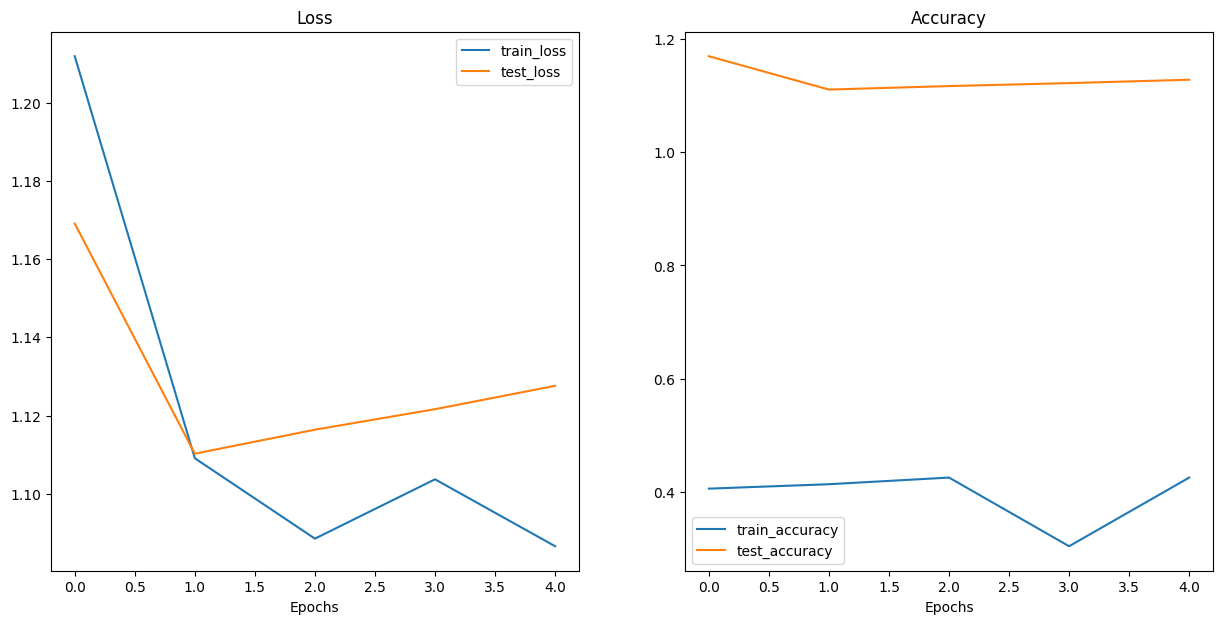

In [65]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few differente ways to do this:
1. Hard coding (what we are doing)
2. PyTorch + Tensorboard
3. Weigths and Biases - https://wandb.ai/site/
4. MLFlow - https://mlflow.org/

In [66]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


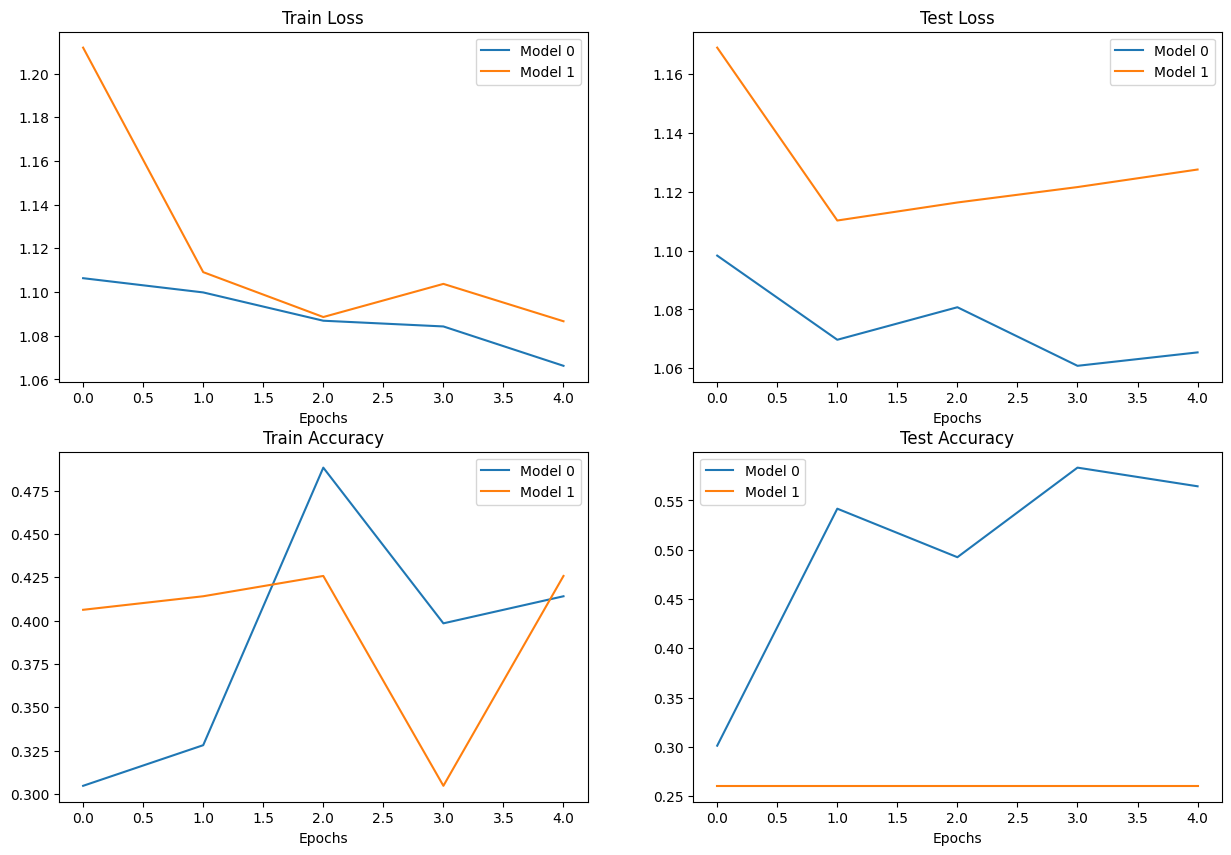

In [70]:
# Setup a plot
plt.figure(figsize=(15,10))

# GEt number of epochs
epochs = range(len(model_0_df))

# Plot for the train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label= "Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot for the test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label= "Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot for the train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label= "Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot for the test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label= "Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either the training or testing dataset.

In [72]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path/ "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/main/generated/torchvision.io.decode_image.html#torchvision.io.decode_image

In [77]:
import torchvision

# Read in custom image
custom_image_unint8 = torchvision.io.decode_image(custom_image_path)
print(f"Custom image tensor:\n {custom_image_unint8}")
print(f"Custom image shape: {custom_image_unint8.shape}")
print(f"Custom image datatype: {custom_image_unint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [78]:
# Try to make a prediction on an image in unint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_unint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [79]:
# Load in the custom image and convet to torch.float32
custom_image = torchvision.io.decode_image(str(custom_image_path)).type(torch.float32)/255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [82]:
# Create transform pipeline to resize the image
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print ou the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


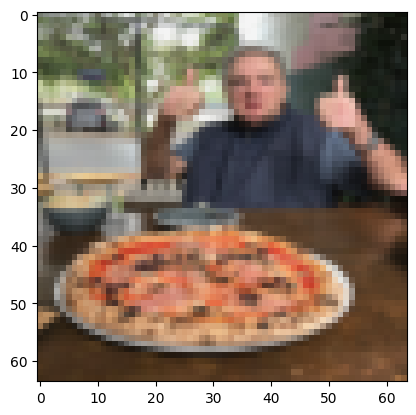

In [83]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [84]:
# This will error not batch size
#model_1.eval()
#with torch.inference_mode():
 # custom_image_pred = model_1(custom_image_transformed).to(device)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [86]:
# Added a batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0)).to(device)

custom_image_pred

tensor([[ 0.1013, -0.0288, -0.1049]])

**Note:** to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as he model (torch.float32)
* Make sure the images shapes as the data model was trained on (3,64,64) with a batch size... (1,3,64,64)
* Make sure the image was on the same device as our model


In [87]:
# Convert logits -> prediction probabilites
custom_image_pred_probs = torch.softmax(custom_image_pred, dim =1)
custom_image_pred_probs

tensor([[0.3715, 0.3262, 0.3023]])

In [90]:
# Convert prediction probabilites -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim =1).cpu()
custom_image_pred_label

tensor([0])

### 11.3 Putting custom prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [96]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

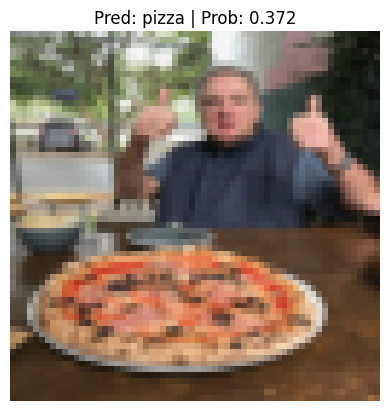

In [97]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)